In [1]:
import numpy as np
import pandas as pd
import nltk
import pickle
from nltk.stem import PorterStemmer
import re
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


# Read the Data

In [2]:
movies_df = pd.read_csv('data/plot_summaries.txt', sep='	')
movies_meta_df = pd.read_csv('data/movie.metadata.tsv', sep='	')
print("Number of movies loaded: %s " % (len(movies_df)))

Number of movies loaded: 42303 


In [3]:
with open('data/stopwords.pkl', 'rb') as f:
    stopwords = pickle.load(f)

In [4]:
movies_df.head(5)

,Wikipedia movie ID,movie_plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [5]:
movies_meta_df.head(5)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples)
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [6]:
movies_df = pd.merge(movies_df, movies_meta_df, on="Wikipedia movie ID")
movies_df.head(5)

,Wikipedia movie ID,movie_plot,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples)
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",/m/076w2lb,Taxi Blues,1990-09-07,NaN,110.0,"{""/m/06b_j"": ""Russian Language""}","{""/m/0f8l9c"": ""France"", ""/m/05vz3zq"": ""Soviet ...","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci..."
1,31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,/m/051zjwb,Narasimham,2000,NaN,175.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",/m/06xtz3,The Lemon Drop Kid,1951-03-08,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,/m/02tqm5,A Cry in the Dark,1988-11-03,6908797.0,121.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


In [7]:
# Stopwords visualisation
print(stopwords)
print(len(stopwords))

{'', 'according', 'hopefully', "couldn't", 'few', 'm', 'indeed', 'these', 'of', 'come', 'insofar', "c'mon", 'above', 'none', 'throughout', 'gives', 'right', 'anyway', "it's", 'different', 'gets', 'whenever', 'welcome', "haven't", 'toward', 'regarding', 'we', 'afterwards', "we've", 'probably', 'overall', 'course', 'indicate', 'contain', 'q', "it'd", "they've", 'how', 'whoever', 'what', 'seen', "ain't", 'yet', 'ones', 'this', 'are', 'less', 'given', 'indicated', 'is', 'mostly', "wouldn't", 'myself', 'some', 'might', 'before', 'liked', 'and', 'like', 'herself', 'using', 'formerly', 'either', 'thru', 'whether', 'else', 'appropriate', 'zero', 'hereby', 'were', 'sub', 'o', 'tried', 'sure', 'doing', 'hereupon', 'also', 'ever', 'que', 'able', 'uses', 'getting', 'serious', 'tell', 'get', 're', 'whence', 'with', 'i', 'although', 'definitely', 'unto', 'no', 'thorough', 'nine', 'not', 'twice', 'yours', "can't", 'inner', 'wherever', 'out', 'go', 'ought', 'v', "where's", 'thereafter', 'otherwise', '

In [8]:
movies_df['Movie languages'].value_counts()

{"/m/02h40lc": "English Language"}                                                                                                                                                                                                     20548
{}                                                                                                                                                                                                                                      5264
{"/m/03k50": "Hindi Language"}                                                                                                                                                                                                          1692
{"/m/07c9s": "Tamil Language"}                                                                                                                                                                                                           970
{"/m/064_8sq": "French Language"}                   

<AxesSubplot:>

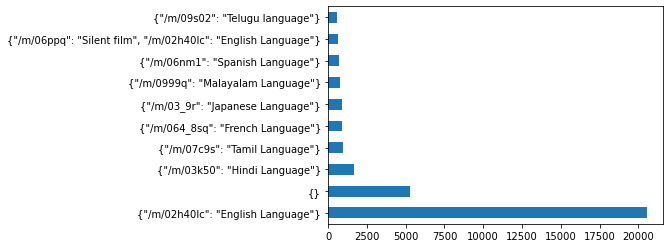

In [9]:
movies_df['Movie languages'].value_counts()[:10].plot(kind='barh')

In [10]:
def high_low(column):
    #for highest value in column
    high= movies_df[column].idxmax()
    high_details=pd.DataFrame(movies_df.loc[high])
    
    #for lowest value in column
    low= movies_df[column].idxmin()
    low_details=pd.DataFrame(movies_df.loc[low])
    
    #collectin data in one place
    info=pd.concat([high_details, low_details], axis=1)
    
    return info

In [11]:
high_low('Movie box office revenue')

,30743,25584
Wikipedia movie ID,4273140,29085210
movie_plot,"By 2154, humans have severely depleted Earth'...",The basic tenet of GhettoPhysics is that the P...
Freebase movie ID,/m/0bth54,/m/0dll0nz
Movie name,Avatar,GhettoPhysics
Movie release date,2009-12-10,2010
Movie box office revenue,2782275172.0,10200.0
Movie runtime,178.0,NaN
Movie languages,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...",{}
Movie countries (Freebase ID:name tuples),"{""/m/09c7w0"": ""United States of America"", ""/m/...",{}
Movie genres (Freebase ID:name tuples),"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","{""/m/0cshrf"": ""Political cinema"", ""/m/0jtdp"": ..."


In [12]:
movies_df['Movie box office revenue'].describe()

count    7.587000e+03
mean     5.175973e+07
std      1.167179e+08
min      1.020000e+04
25%      2.500000e+06
50%      1.242118e+07
75%      4.559722e+07
max      2.782275e+09
Name: Movie box office revenue, dtype: float64

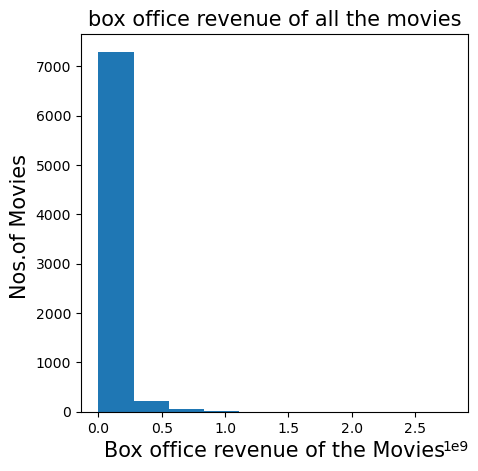

In [13]:
#plotting a histogram of box office revenue of movies

#giving the figure size(width, height)
plt.figure(figsize=(5,5), dpi = 100)

#On x-axis 
plt.xlabel('Box office revenue of the Movies', fontsize = 15)
#On y-axis 
plt.ylabel('Nos.of Movies ', fontsize=15)
#Name of the graph
plt.title('box office revenue of all the movies', fontsize=15)

#giving a histogram plot
plt.hist(movies_df['Movie box office revenue'])
#displays the plot
plt.show()

/home/raymond/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


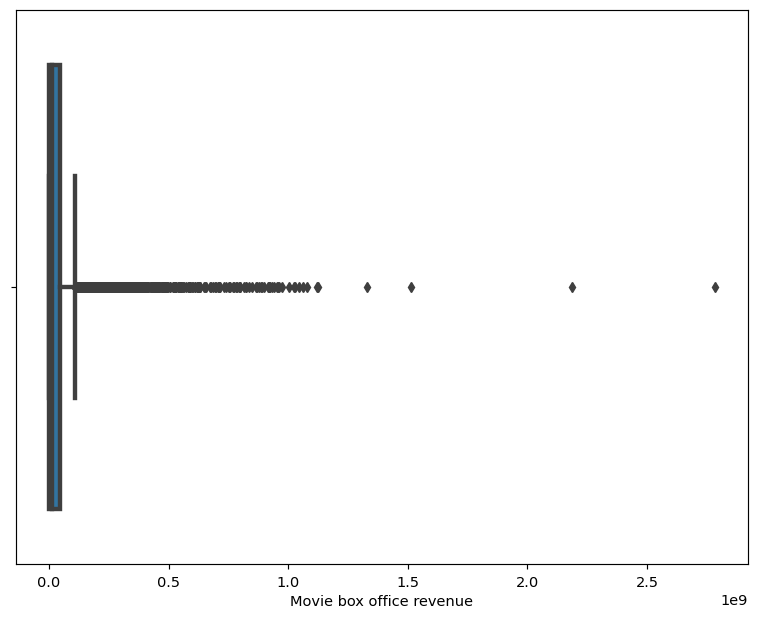

In [14]:
#The First plot is box plot of the box office revenue of the movies 
plt.figure(figsize=(9,7), dpi = 105)

#using seaborn to generate the boxplot
sns.boxplot(movies_df['Movie box office revenue'], linewidth = 3)
#diplaying the plot
plt.show()

In [15]:
high_low('Movie runtime')

,14839,31155
Wikipedia movie ID,10815585,10500661
movie_plot,After surviving a sneak attack on himself and ...,The film opens with a shot of the North Sea Ca...
Freebase movie ID,/m/02qqy23,/m/02qfzt4
Movie name,Zero Tolerance,Opening of the Kiel Canal
Movie release date,1995,1895
Movie box office revenue,NaN,NaN
Movie runtime,1079281.0,0.3
Movie languages,"{""/m/02h40lc"": ""English Language""}","{""/m/06ppq"": ""Silent film""}"
Movie countries (Freebase ID:name tuples),"{""/m/09c7w0"": ""United States of America""}","{""/m/07ssc"": ""United Kingdom""}"
Movie genres (Freebase ID:name tuples),"{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."


In [16]:
movies_df['Movie runtime'].describe()

count    3.558000e+04
mean     1.285403e+02
std      5.721460e+03
min      3.000000e-01
25%      8.600000e+01
50%      9.600000e+01
75%      1.100000e+02
max      1.079281e+06
Name: Movie runtime, dtype: float64

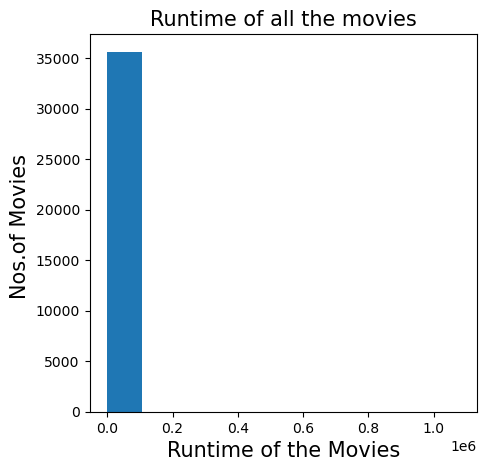

In [17]:
#plotting a histogram of runtime of movies

#giving the figure size(width, height)
plt.figure(figsize=(5,5), dpi = 100)

#On x-axis 
plt.xlabel('Runtime of the Movies', fontsize = 15)
#On y-axis 
plt.ylabel('Nos.of Movies ', fontsize=15)
#Name of the graph
plt.title('Runtime of all the movies', fontsize=15)

#giving a histogram plot
plt.hist(movies_df['Movie runtime'])
#displays the plot
plt.show()

/home/raymond/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


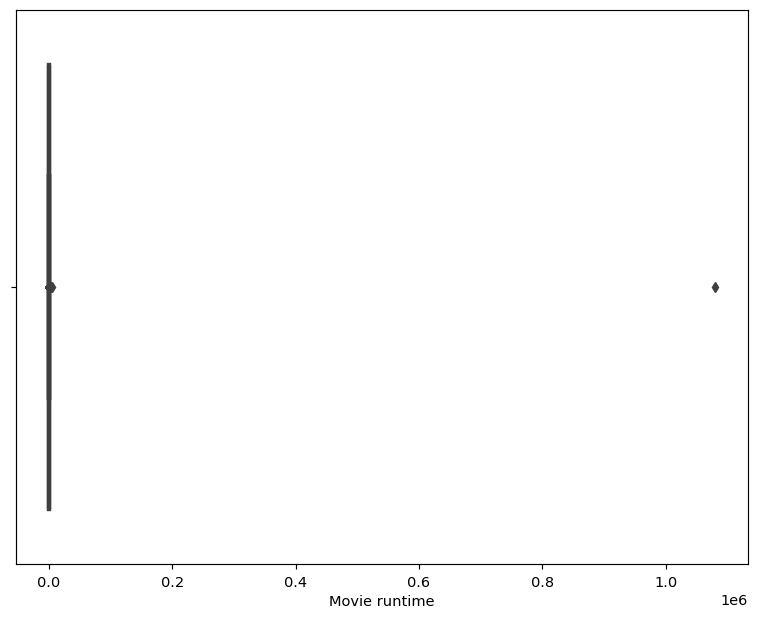

In [18]:
#The First plot is box plot of the runtime of the movies 
plt.figure(figsize=(9,7), dpi = 105)

#using seaborn to generate the boxplot
sns.boxplot(movies_df['Movie runtime'], linewidth = 3)
#diplaying the plot
plt.show()

In [19]:
movies_df['Movie release year'] = movies_df['Movie release date'].astype(str).str[:4]
movies_df = movies_df[movies_df["Movie release year"].str.contains("nan") == False]
movies_df['Movie release year'].astype(int)
movies_df

,Wikipedia movie ID,movie_plot,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),Movie release year
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",/m/076w2lb,Taxi Blues,1990-09-07,NaN,110.0,"{""/m/06b_j"": ""Russian Language""}","{""/m/0f8l9c"": ""France"", ""/m/05vz3zq"": ""Soviet ...","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci...",1990
1,31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":...",2012
2,20663735,Poovalli Induchoodan is sentenced for six yea...,/m/051zjwb,Narasimham,2000,NaN,175.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""...",2000
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",/m/06xtz3,The Lemon Drop Kid,1951-03-08,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""...",1951
4,595909,Seventh-day Adventist Church pastor Michael Ch...,/m/02tqm5,A Cry in the Dark,1988-11-03,6908797.0,121.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988
...,...,...,...,...,...,...,...,...,...,...,...
42199,34808485,"The story is about Reema , a young Muslim scho...",/m/0j3dcl6,Oomakkuyil Padumbol,2012-02-17,NaN,NaN,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/0bj8m2"": ""Children's""}",2012
42200,1096473,"In 1928 Hollywood, director Leo Andreyev look...",/m/045pct,The Last Command,1928,NaN,88.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi...",1928
42201,35102018,American Luthier focuses on Randy Parsons’ tra...,/m/0j6777g,Randy Parsons: American Luthier,2011-10-04,NaN,8.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/04rlf"": ""Music...",2011
42202,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",/m/04f7jfs,Kabuliwala,1961-12-14,NaN,134.0,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/07s9rl0"": ""Drama""}",1961


In [20]:

profits_year = movies_df.groupby('Movie release year')['Movie box office revenue'].sum()

#figure size(width, height)
plt.figure(figsize=(12,6), dpi = 1300)

#on x-axis
plt.xlabel('Release Year of Movies in the data set', fontsize = 12)
#on y-axis
plt.ylabel('Box office', fontsize = 12)
#title of the line plot
plt.title('Representing Total box office revenue by all movies Vs Year of their release.')

#plotting the graph
plt.plot(profits_year)

#displaying the line plot
plt.show()

# Tokenization & Stemming

In [21]:
def tokenize_and_stem(text):
    
    # Tokenize by sentence, then by word
    sent_tokenized = [sent for sent in nltk.sent_tokenize(text)]
    words_tokenized = [word for word in nltk.word_tokenize(sent_tokenized[0])]
    
    # Filter out raw tokens to remove noise
    filtered_tokens = [token for token in words_tokenized if re.search('[a-zA-Z]', token)]
    
    # Stem the filtered_tokens
    stems = [PorterStemmer().stem(t) for t in filtered_tokens]
    
    return stems

words_stemmed = tokenize_and_stem(movies_df['movie_plot'][0])
print(words_stemmed)

['shlykov', 'a', 'hard-work', 'taxi', 'driver', 'and', 'lyosha', 'a', 'saxophonist', 'develop', 'a', 'bizarr', 'love-h', 'relationship', 'and', 'despit', 'their', 'prejudic', 'realiz', 'they', 'are', "n't", 'so', 'differ', 'after', 'all']


In [22]:
# Instantiate TfidfVectorizer object with stopwords and tokenizer
# parameters for efficient processing of text
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem,
                                 ngram_range=(1,3))

In [23]:
tfidf_matrix = tfidf_vectorizer.fit_transform([x for x in movies_df["movie_plot"]])

print(tfidf_matrix.shape)

/home/raymond/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words

(39586, 1)


In [24]:
# Create a KMeans object with 5 clusters and save as km
km = KMeans(n_clusters=3)

# Fit the k-means object with tfidf_matrix
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

# Create a column cluster to denote the generated cluster for each movie
movies_df["cluster"] = clusters

# Display number of films per cluster (clusters from 0 to 4)
movies_df['cluster'].value_counts() 

/tmp/ipykernel_114191/1114203756.py:5: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(tfidf_matrix)


0    29863
1     9723
Name: cluster, dtype: int64

In [ ]:
# Calculate the similarity distance
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

In [ ]:
# Create mergings matrix 
mergings = linkage(similarity_distance, method='complete')

# Plot the dendrogram, using title as label column
dendrogram_ = dendrogram(mergings,
               labels=[x for x in movies_df["Movie name"]],
               leaf_rotation=90,
               leaf_font_size=16,
)

# Adjust the plot
fig = plt.gcf()
_ = [lbl.set_color('r') for lbl in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(108, 21)

# Show the plotted dendrogram
plt.show()